In [243]:
# packages

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir('C:\\Users\\s232055\\OneDrive\\Asztali gép\\Python\\46310 Wind Turbine Aeroelacticity')  # change this to your directory

In [244]:
# functions

def compute_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
misc_1_tab=np.zeros([105,6])
misc_2_tab=np.zeros([105,6])
misc_3_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],misc_1_tab[:,i],misc_2_tab[:,i],misc_3_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

# Thickness of the airfoils considered
# NOTE THAT IN PYTHON THE INTERPOLATION REQUIRES THAT THE VALUES INCREASE IN THE VECTOR!

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    
    return cl, cd, cm


# BEM (for 3 blades)

def BEM():

    theta_blade1_old = 0 # initial position [rad]

    # creating empty arrays to store values
    Wy_old = np.zeros(len(r_array)+1)
    Wz_old = np.zeros(len(r_array)+1)

    Wy_qs = np.zeros(len(r_array))
    Wz_qs = np.zeros(len(r_array))

    P = []
    T = []
    time_array = []

    # time step iteration
    for n in range(num):

        # simulation time [s]
        time = n*dt
        time_array.append(time)

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_time = []
        T_time = []

        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing P, T, py, pz values for each segment
            dP_array = []
            dT_array = []
            py_array = []
            pz_array = []

            # blade segment iteration
            for i in range(len(r_array)):
            
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                # final wind components in CS1 [m/s]
                Vx = 0
                Vz =  z/r_1 * Vr + y/r_1 * Vtheta
                Vy =  y/r_1 * Vr - z/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy_old[i] - omega*r*np.cos(theta_cone) # tangential
                Vrel_z = V0_4[2] + Wz_old[i] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch) # angle of attack [rad]

                # lift and drag coefficients
                Cl, Cd, Cm = force_coeffs_10MW(np.rad2deg(alpha), thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab)
                
                # induction factor and Glauert correction
                a = - Wz_old[i]/ V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wz_qs[i] = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz_old[i])**2))
                Wy_qs[i] = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz_old[i])**2))

                # updating induced wind [[guess based in 46300 VAWT unsteady BEM code]]
                tau = 2*R/V0 # time constant

                Wz = Wz_qs[i] + (Wz_old[i] - Wz_qs[i])*np.exp(-dt/tau)
                Wy = Wy_qs[i] + (Wy_old[i] - Wy_qs[i])*np.exp(-dt/tau)

                Wz_old[i] = Wz
                Wy_old[i] = Wy

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array.append(dP)
                dT_array.append(dT)
                py_array.append(py)
                pz_array.append(pz)

            # integrating segment values to get P and T per blade
            P_blade = integrate.simps(y=dP_array, x=r_array)
            T_blade = integrate.simps(y=dT_array, x=r_array)
            
            P_time.append(P_blade)
            T_time.append(T_blade)
        
        P.append(P_time)
        T.append(T_time)

        # updating blade location
        theta_blade1_old = theta_blade1

    return np.array(P), np.array(T), np.array(time_array), py_array, pz_array

In [245]:
# global + Q1 data

B = 3 # number of blades
rho = 1.225 # air density [kg/m3]
R = 89.17 # rotor diameter [m]

omega = 7.229 *2*np.pi/60 # rotational speed [rad/s]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m]    

# r_target = 65.75 # radius of the interesting blade segment [m]
r_target = 9 # index of the interesting blade segment

# reading blade geometry data from file
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]

theta_pitch = np.deg2rad(0) # pitch angle [rad]

# wind
nu = 0.0 # wind shear exponent
V0 = 9 # mean wind speed at hub height [m/s]

# simulation parameters
t_total = 50 # total time of simulation [s]
dt = 0.05 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

In [246]:
# Q1 calculation

P, T , time_array, pt, pn = BEM()

C:\Users\s232055\AppData\Local\Temp\ipykernel_1996\2514998208.py:232: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  P_blade = integrate.simps(y=dP_array, x=r_array)
C:\Users\s232055\AppData\Local\Temp\ipykernel_1996\2514998208.py:233: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  T_blade = integrate.simps(y=dT_array, x=r_array)


In [247]:
# Q1 results

# reference values from DTU 10 MW report
ref_P = 5311.8e3 # power [W]
ref_T = 1009.1e3 # thrust [N]

# calculating relative errors [%]
diff_P = ((P[-1,0]+P[-1,1]+P[-1,2]) - ref_P) /ref_P *100
diff_T = ((T[-1,0]+T[-1,1]+T[-1,2]) - ref_T) /ref_T *100

print("Difference between steady power and reference value is " + str(diff_P) + "%")
print("Difference between steady thrust and reference value is " + str(diff_T) + "%")

Difference between steady power and reference value is -2.1802205454049393%
Difference between steady thrust and reference value is -1.499535323885896%


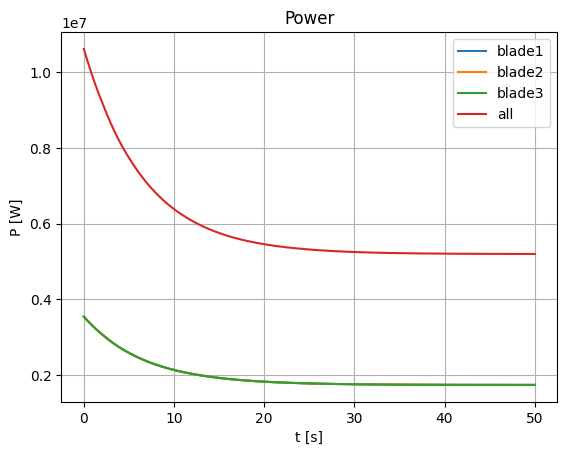

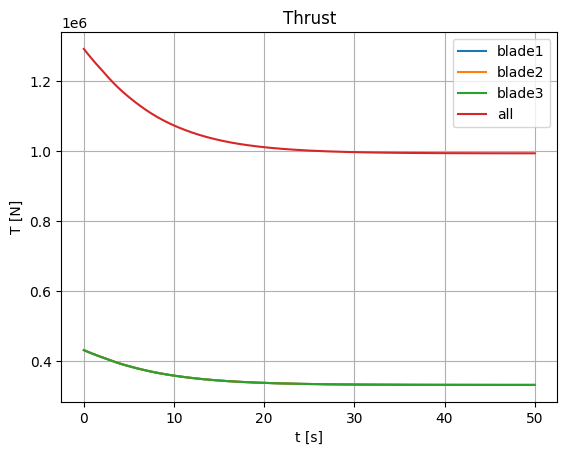

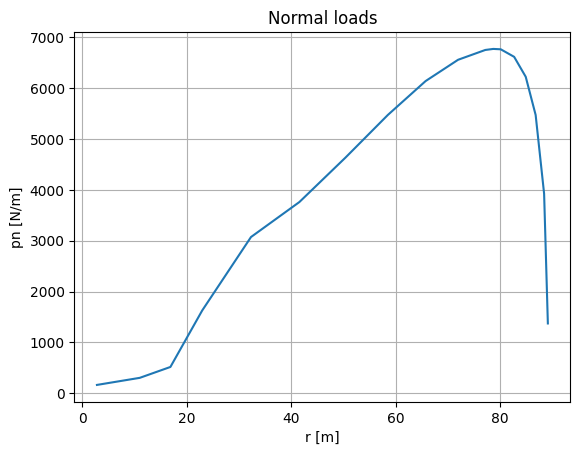

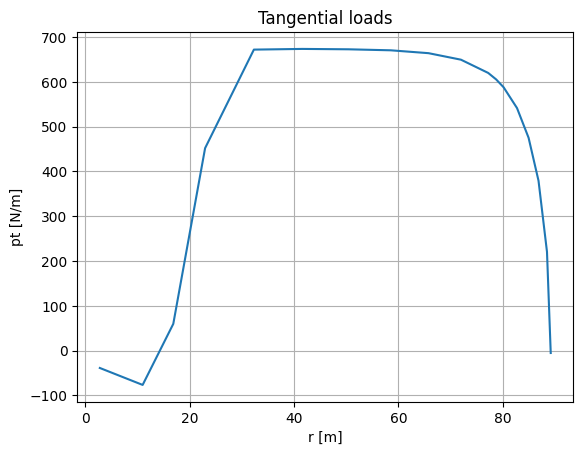

In [248]:
# Q1 plots

# powers (per blade)
plt.figure()
plt.plot(time_array, P[:,0], label='blade1')
plt.plot(time_array, P[:,1], label='blade2')
plt.plot(time_array, P[:,2], label='blade3')
plt.plot(time_array, (P[:,0]+P[:,1]+P[:,2]), label='all')
plt.grid()
plt.title('Power')
plt.xlabel('t [s]')
plt.ylabel('P [W]')
plt.legend(loc='upper right')
plt.show()

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend(loc='upper right')
plt.show()

# normal loads (steady, per blade)
plt.figure()
plt.plot(r_array, pn)
plt.grid()
plt.title('Normal loads')
plt.xlabel('r [m]')
plt.ylabel('pn [N/m]')
plt.show()

# tangential loads (steady, per blade)
plt.figure()
plt.plot(r_array, pt)
plt.grid()
plt.title('Tangential loads')
plt.xlabel('r [m]')
plt.ylabel('pt [N/m]')
plt.show()

In [249]:
# Q2 calculation

# adding wind shear exponent
nu = 0.2

### # NO IDEA WHETHER WE NEED TOWER EFFECT OR NOT
### # adding tower effect
### a0 = 3.32 # tower radius [m]

P, T , time_array, pt, pn = BEM()

C:\Users\s232055\AppData\Local\Temp\ipykernel_1996\2514998208.py:232: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  P_blade = integrate.simps(y=dP_array, x=r_array)
C:\Users\s232055\AppData\Local\Temp\ipykernel_1996\2514998208.py:233: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  T_blade = integrate.simps(y=dT_array, x=r_array)


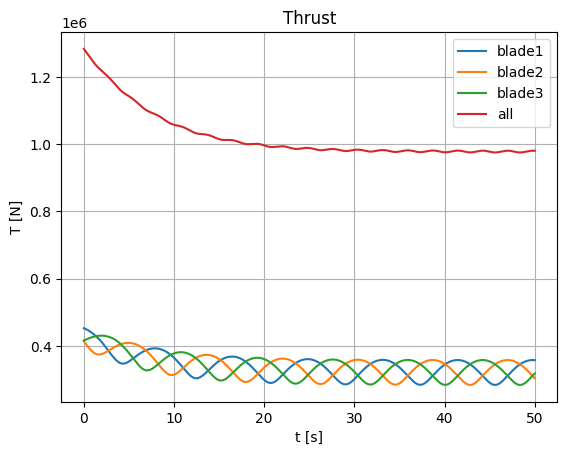

In [250]:
# Q2 plots

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend(loc='upper right')
plt.show()